# Modern Time Series Analysis at SciPy 2019 by Aileen Nielsen

Seminar by Aileen Nielsen on some more advanced analysis techniques (Bayesian methods, machine learning, deep learning). Taking notes and trying out a few things. [Video](youtube.com/watch?v=v5ijNXvlC5A).



Common time series analysis tasks:

* Visualization and EDA including understanding trends, seasonality, stationarity, identifying underlying distributions and nature of temporal process producing data.
* Estimation of past, present future. 
* Classification.
* Anomaly detection.

Some characteristics that can complicate analysis:

* More likely to contain missing data than cross-sectional data (difficulty of collecting measurements over time).
* May have high degree of correlation between data points, which is good news for prediction tasks, but not so great for modeling tasks that need independent inputs to function well. 
* Time stamps introduce messiness in the form of time zones, frequency irregularities and so on.

A few more characteristics to bear in mind:

* Data is collected sequentially and one axis is increasing monotonically.
* Structure, such as seasonality, cycles, autocorrelation, trends, is characterized across data points.
* A single time series can display different behaviours over time and you need to be able to detect these shifts (e.g., change points and regime shifts versus drift and gradual change).



## State space models for time series

### Box-Jenkins ARIMA models

Excellent performance on small data sets. Remains close to cutting edge performance. It imposes a high hurdle on modern techniques to overcome. [ARIMA on wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and [Box-Jenkins](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method). Box-Jenkins and ARIMA models are used to predict future values based on past values and errors.

Downsides:

* Not especially intuitive how it works.
* Some systems cycle more slowly or stochastically than can be easily described with an ARIMA model. 
* Performance flattens out on large dataset (good on tens of data points, less so on tens of thousands).

State space models offer their services in three stages:

![What state space models buy us](./images/state-space-models-uses.png)

Common techniques: Kalman Filter, local linear trend, smooth trend.

**Akaike Information Criterion (AIC)** is a measure used to evaluate state space models.

Coding along and exploring whatever seems interesting.

In [16]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = [10, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)

3.1.1
0.25.3
1.18.1
0.10.1
1.3.1


In [7]:
df = pd.read_csv("data/global_temps.csv")
df.head(12)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292
5,GISTEMP,2016-10-06,0.8900
6,GCAG,2016-09-06,0.8767
7,GISTEMP,2016-09-06,0.8700
8,GCAG,2016-08-06,0.8998
9,GISTEMP,2016-08-06,0.9800


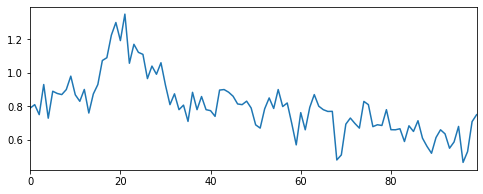

In [6]:
df.Mean[:100].plot()

There are two problems with this data set. One, we would like the x-axis to represent time and two, it looks like we are dealing with two time series signals here (i.e. `GCAG` and `GISTEMP`) and so ideally we want to be able to look at each separately.

In [8]:
df = df.pivot(index="Date", columns="Source", values="Mean")
df.head(12)

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


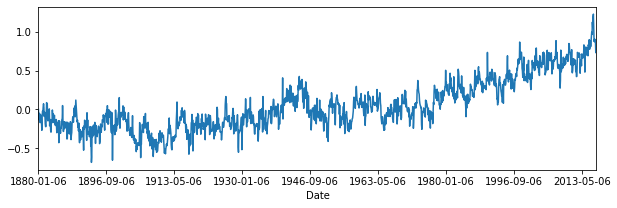

In [17]:
df["GCAG"].plot()

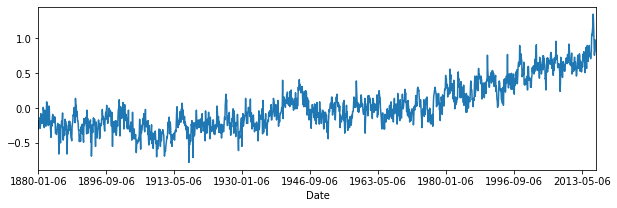

In [18]:
df["GISTEMP"].plot()

In [19]:
type(df.index)

pandas.core.indexes.base.Index

The index is not time-aware yet (just a bunch of numbers with hypens thrown in). We can convert these values to a proper `DatetimeIndex`.

In [20]:
df.index = pd.to_datetime(df.index)

In [21]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

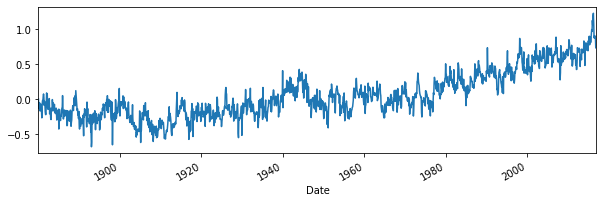

In [22]:
df.GCAG.plot()

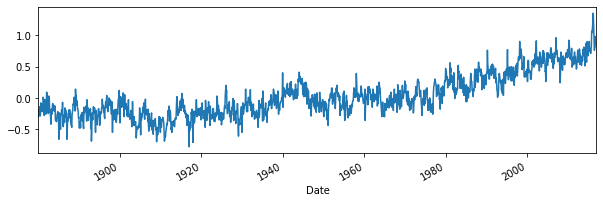

In [23]:
df.GISTEMP.plot()

Can index by year now.

In [24]:
df["1880"]

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


Or do some basic computations on the index.

In [29]:
print(f"min: {df.index.min()}, max: {df.index.max()}")

min: 1880-01-06 00:00:00, max: 2016-12-06 00:00:00


Plot data for time ranges (for both time series).

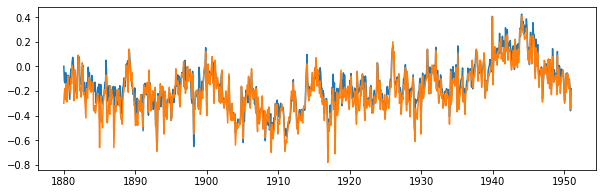

In [40]:
plt.plot(df["1880":"1950"][["GCAG", "GISTEMP"]])

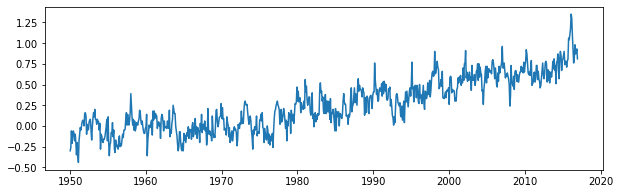

In [46]:
plt.plot(df["1950":]["GISTEMP"])

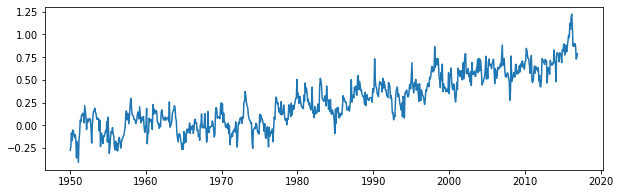

In [47]:
plt.plot(df["1950":]["GCAG"])

How strongly do these measurements correlated contemporaneously? 

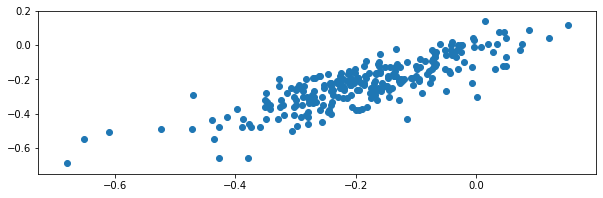

In [50]:
plt.scatter(df["1880":"1900"][["GCAG"]], df["1880":"1900"][["GISTEMP"]])

In [53]:
pearsonr(df["1880":"1900"].GCAG, df["1880":"1900"].GISTEMP)

(0.8373775278912143, 1.5894725243749507e-67)

What about if we add a time lags?

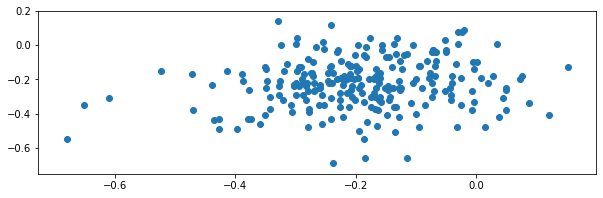

In [51]:
plt.scatter(df["1880":"1899"][["GCAG"]], df["1881":"1900"][["GISTEMP"]])

In [55]:
pearsonr(df["1880":"1899"].GCAG, df["1881":"1900"].GISTEMP)

(0.15464057329612763, 0.01650223473095511)

In [56]:
df["1880":"1899"].GCAG.head()

Date
1880-01-06    0.0009
1880-02-06   -0.1229
1880-03-06   -0.1357
1880-04-06   -0.0499
1880-05-06   -0.0738
Name: GCAG, dtype: float64

In [57]:
df["1881":"1900"].GISTEMP.head()

Date
1881-01-06   -0.10
1881-02-06   -0.14
1881-03-06    0.01
1881-04-06   -0.03
1881-05-06   -0.04
Name: GISTEMP, dtype: float64

### Unobserved components model

* Create a training set that consists of data from 1960 onward. 
* Define the parameters for a smooth trend model without cyclical or seasonal components.
* Fit an unobserved components model.


In [61]:
train = df["1960":]

In [62]:
model = { "level": "smooth trend", "cycle": False, "seasonal": None }

In [64]:
gcag_model = sm.tsa.UnobservedComponents(train["GCAG"], **model)
gcag_res = gcag_model.fit()

/Users/brunow/anaconda3/envs/py37scipy/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


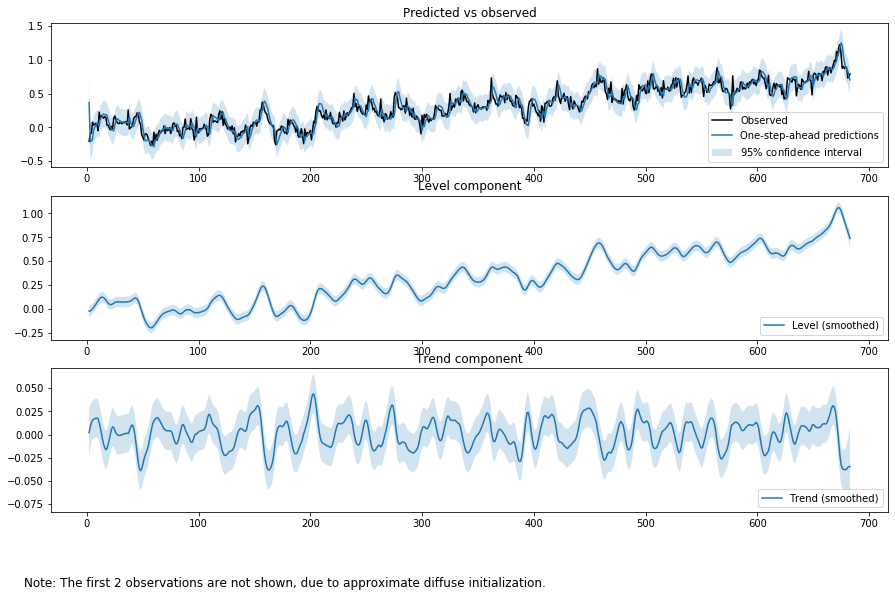

In [66]:
fig = gcag_res.plot_components(legend_loc="lower right", figsize=(15, 9))

Note that this is a one-step ahead prediction, so predicting temperates one month ahead.

Cannot really tell much from the trend graph. It does not look like there is a trend.

Predict 20 steps (months) ahead using the previous prediction as input for each subsequent prediction.

In [67]:
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train["GCAG"].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

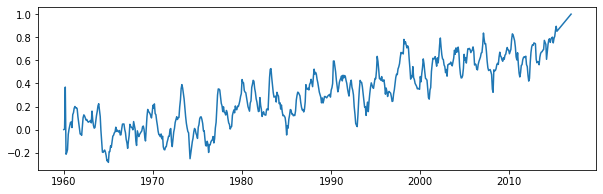

In [71]:
plt.plot(predict)

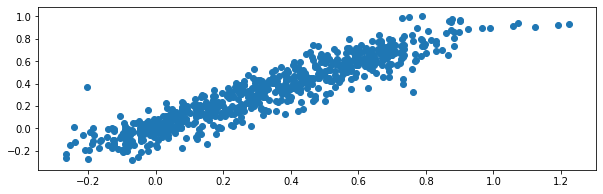

In [72]:
plt.scatter(train["GCAG"], predict)

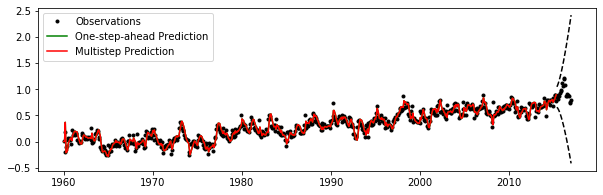

In [91]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train["GCAG"], "k.", label="Observations");
ax.plot(train.index[:-num_steps], predict[:-num_steps], "g", label="One-step-ahead Prediction");

ax.plot(train.index[:-num_steps], predict[:-num_steps], "r", label="Multistep Prediction");
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

## Machine learning methods for time series

## Deep learning for time series 